In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import cycle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix
from xgboost import plot_importance
from scipy import interp

%matplotlib inline

In [13]:
data = pd.read_csv('edm_songs.csv')

features = ['acousticness', 'instrumentalness', 'speechiness', 'danceability', 
            'liveness', 'valence', 'energy', 'loudness',
            'tempo', 'duration_ms']

genres = ['techhouse', 'techno', 'trance', 'psytrance', 'trap', 'dnb', 'hardstyle']

In [14]:
data.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,title
0,0,0.806,0.950,7,-6.782,1,0.0811,0.000957,0.920,0.1130,...,127.997,audio_features,5LzAV6KfjN8VhWCedeygfY,spotify:track:5LzAV6KfjN8VhWCedeygfY,https://api.spotify.com/v1/tracks/5LzAV6KfjN8V...,https://api.spotify.com/v1/audio-analysis/5LzA...,197499,4,techhouse,Dirtybird Players
1,1,0.803,0.697,6,-9.479,1,0.0599,0.000130,0.888,0.3560,...,126.008,audio_features,6nxvhvk9etkPBXXzsLP6re,spotify:track:6nxvhvk9etkPBXXzsLP6re,https://api.spotify.com/v1/tracks/6nxvhvk9etkP...,https://api.spotify.com/v1/audio-analysis/6nxv...,507998,4,techhouse,Tech House Movement
2,2,0.729,0.978,10,-6.645,1,0.0420,0.062300,0.908,0.0353,...,124.994,audio_features,3TsCb6ueD678XBJDiRrvhr,spotify:track:3TsCb6ueD678XBJDiRrvhr,https://api.spotify.com/v1/tracks/3TsCb6ueD678...,https://api.spotify.com/v1/audio-analysis/3TsC...,206000,4,techhouse,tech house
3,3,0.724,0.792,4,-8.555,0,0.0405,0.019100,0.812,0.1080,...,124.006,audio_features,6Y0Fy2buEis7bEOlG0QET1,spotify:track:6Y0Fy2buEis7bEOlG0QET1,https://api.spotify.com/v1/tracks/6Y0Fy2buEis7...,https://api.spotify.com/v1/audio-analysis/6Y0F...,199839,4,techhouse,Tech House Bangerz
4,4,0.700,0.898,8,-6.099,1,0.2570,0.053000,0.418,0.5740,...,125.031,audio_features,4EJI2XGViSQp6WscLKgYDD,spotify:track:4EJI2XGViSQp6WscLKgYDD,https://api.spotify.com/v1/tracks/4EJI2XGViSQp...,https://api.spotify.com/v1/audio-analysis/4EJI...,173861,4,techhouse,tech house


### Data Pre-Processing
Scaling the training data with a min max scalar, as well as encoding the labels to integers.

In [15]:
X = data[features].copy()
y = LabelEncoder().fit_transform(data['genre'])

In [16]:
X.shape

(21000, 10)

In [17]:
y.shape

(21000,)

### Train and Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=123, shuffle=True)

### Min-Max Scaling

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

### Display Results

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [21]:
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

In [22]:
def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(genres))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=genres)

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Test Set Accuracy =  0.84
Test Set F-score =  0.84
ROC AUC = 0.974
Confusion matrix, without normalization
[[599   0   0   0   0   0   1]
 [  1 475  25   0   0  13  86]
 [  2   5 519   3  36  22  13]
 [  0   1   1 520  58  19   1]
 [  0   0  26  41 504  29   0]
 [  0  13  79  17  14 463  14]
 [  7 101   2   2   4  21 463]]
Wall time: 543 ms


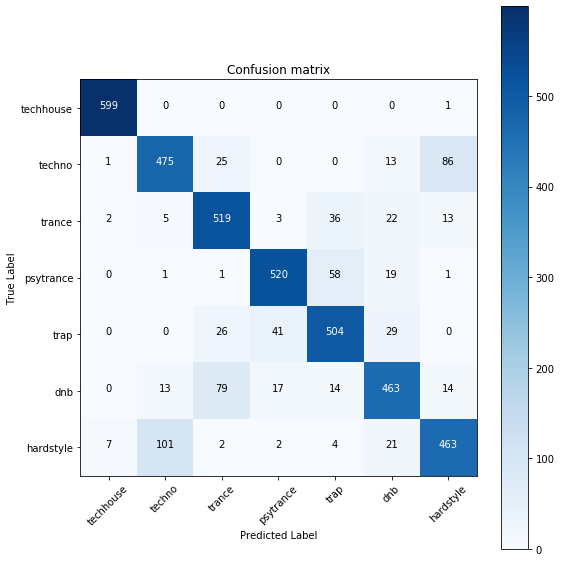

In [23]:
%%time
# Train logistic regression model
logreg = LogisticRegression(penalty='l2', max_iter=10000, multi_class='ovr')
logreg.fit(X_train, y_train)

# Genre prediction and probabilities of each genre
logreg_probs = logreg.predict_proba(X_test)

# Display Results
display_results(y_test, logreg_probs, cm=True)

### Random Forest

In [24]:
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_train, y_train)

In [25]:
# bestF.best_params_

Test Set Accuracy =  0.93
Test Set F-score =  0.93
ROC AUC = 0.994
Confusion matrix, without normalization
[[600   0   0   0   0   0   0]
 [  0 560   5   0   1   0  34]
 [  1   3 550   1   7  29   9]
 [  0   0   0 555  39   6   0]
 [  0   1  22  33 527  17   0]
 [  0   0  13   6  21 557   3]
 [  0  41   3   0   1   8 547]]
Wall time: 40.6 s


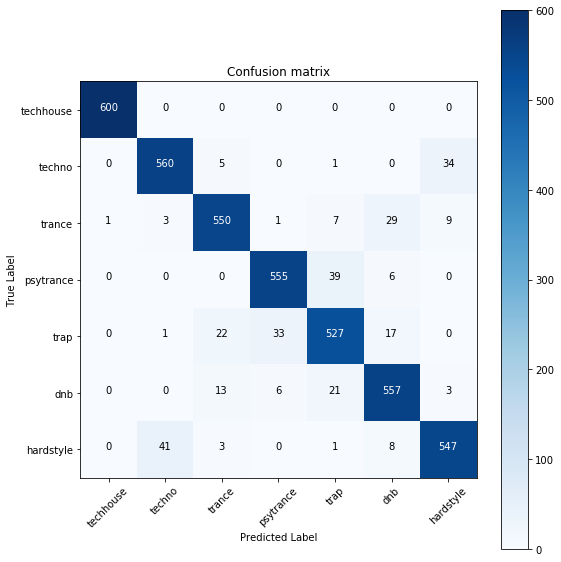

In [26]:
%%time
# Train random forest model with optimal parameters
rf = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200)
rf.fit(X_train, y_train)

# Genre prediction 
rf_probs = rf.predict_proba(X_test)

# Display results
display_results(y_test, rf_probs, cm=True)

### XGBoost

Test Set Accuracy =  0.93
Test Set F-score =  0.93
ROC AUC = 0.994
Confusion matrix, without normalization
[[600   0   0   0   0   0   0]
 [  0 568   5   0   0   0  27]
 [  0   3 553   1  10  25   8]
 [  0   0   0 548  45   7   0]
 [  0   1  18  36 532  13   0]
 [  0   0  11   5  17 562   5]
 [  0  38   6   0   1   7 548]]
Wall time: 54.2 s


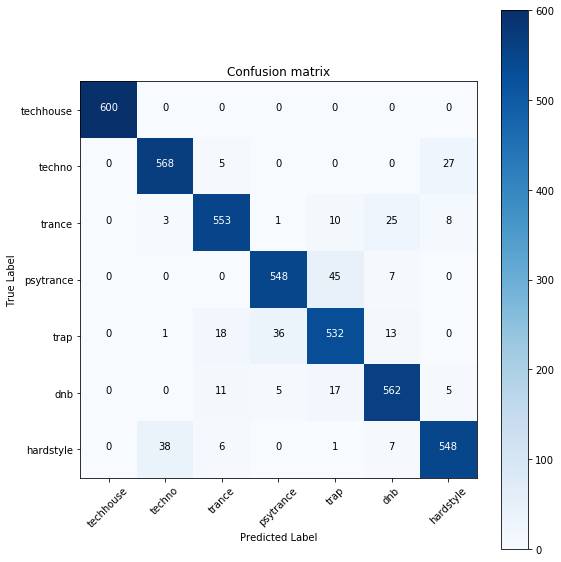

In [27]:
%%time
# Train model with optimal parameters
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                        n_estimators=500, sub_sample = 0.8, num_class = len(genres))
xgb.fit(X_train, y_train)

# Genre prediction 
xgb_probs = xgb.predict_proba(X_test)

# Display results
display_results(y_test, xgb_probs, cm=True)

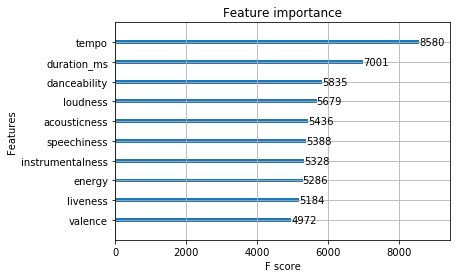

In [28]:
plot_importance(xgb)

### SVM

Test Set Accuracy =  0.88
Test Set F-score =  0.88
ROC AUC = 0.986
Confusion matrix, without normalization
[[600   0   0   0   0   0   0]
 [  0 514  18   0   0   0  68]
 [  2   4 532   1  18  32  11]
 [  0   0   0 526  63  11   0]
 [  0   0  19  39 521  21   0]
 [  0   0  33   7  26 527   7]
 [  1 102  11   0   2  14 470]]
Wall time: 16.1 s


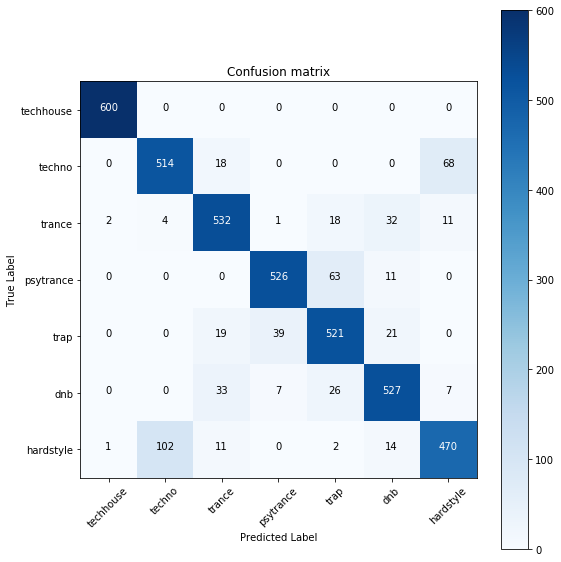

In [29]:
%%time
# Train model with optimal parameters
svm = SVC(gamma='auto', probability=True)
svm.fit(X_train, y_train)

# Genre Prediction
svm_probs = svm.predict_proba(X_test)

# Display results
display_results(y_test, svm_probs, cm=True)

### Evaluate Model Performance

### ROC Curves

In [30]:
def plot_roc_curves(y_true, pred_probs, genres):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(genres)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(genres)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

     # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

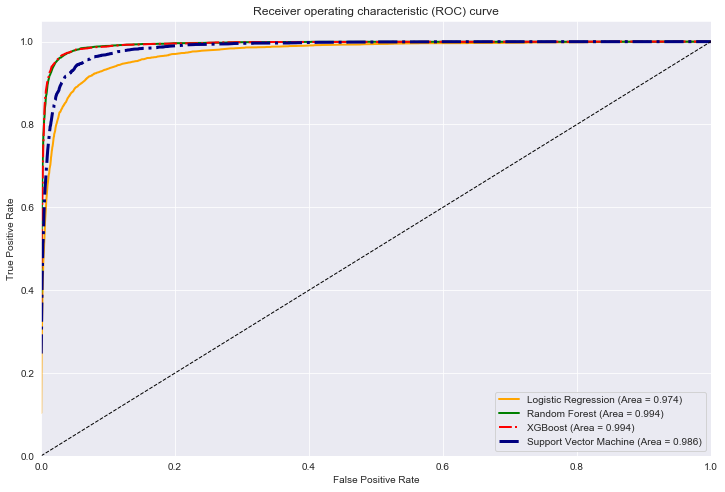

In [31]:
# Plot all ROC curves
plt.figure(figsize=(12,8))
sns.set_style('dark')

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test, logreg_probs, genres)
plt.plot(fpr, tpr,
         label='Logistic Regression (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle='-', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test, rf_probs, genres)
plt.plot(fpr, tpr,
         label='Random Forest (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='-', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test, xgb_probs, genres)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='red', linestyle='-.', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test, svm_probs, genres)
plt.plot(fpr, tpr,
         label='Support Vector Machine (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()